<a href="https://colab.research.google.com/github/viswambhar-yasa/image_captioning/blob/master/training_policy_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/viswambhar-yasa/image_captioning

Cloning into 'image_captioning'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 31 (delta 13), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [2]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile


def downloading_extraction(link, extraction_path='.'):
    url = urlopen(link)
    zipfile = ZipFile(BytesIO(url.read()))
    zipfile.extractall(path=extraction_path)


if __name__ == "__main__":
    images_link = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
    downloading_extraction(images_link)
    text_link = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
    downloading_extraction(text_link)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Embedding, LSTM, BatchNormalization, Bidirectional
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers.recurrent import GRU


def image_encoder(img_input, trainable_layers=0, CNN_Type='Xception', Embed_Size=256, display=False):
    print('Building CNN model')
    if CNN_Type == 'Xception':
        cnn_pre_trained_model = Xception(include_top=False, weights='imagenet', input_tensor=img_input)
    else:
        cnn_pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=img_input)
    for i, layer in enumerate(cnn_pre_trained_model.layers):
        if len(cnn_pre_trained_model.layers) - i < trainable_layers:
            layer.trainable = True
        else:
            layer.trainable = False
    cnn_inputs = cnn_pre_trained_model.inputs
    base_model = cnn_pre_trained_model.output
    base_model = GlobalAveragePooling2D(name='global_average_pooling')(base_model)
    embed_image = tf.keras.layers.Dense(Embed_Size, activation='tanh', name='embed_image')(base_model)
    feature_extraction_model = Model(inputs=cnn_inputs, outputs=embed_image, name='CNN encoder model')
    print('CNN model {output shape}:', embed_image.shape)
    if display:
        tf.keras.utils.plot_model(feature_extraction_model, to_file='base_model.png', show_shapes=True)
    return feature_extraction_model


def txt_decoder(rnn_input, Embed_Size=256, Bi_Direction=False, RNN_Type='LSTM', RNN_Layers=2):
    print('Building RNN model')
    for i in range(RNN_Layers):
        x = BatchNormalization()(rnn_input)
        if RNN_Type == 'LSTM':
            if i == (RNN_Layers - 1):
                if Bi_Direction:
                    rnn_out = Bidirectional(LSTM(int(Embed_Size/2)))(x)
                else:
                    rnn_out = LSTM(Embed_Size)(x)
            else:
                if Bi_Direction:
                    rnn_out = Bidirectional(LSTM(int(Embed_Size/2), return_sequences=True))(x)
                else:
                    rnn_out = LSTM(Embed_Size, return_sequences=True)(x)
        else:
            if i == (RNN_Layers - 1):
                if Bi_Direction:
                    rnn_out = Bidirectional(GRU(Embed_Size))(x)
                else:
                    rnn_out = GRU(Embed_Size)(x)
            else:
                if Bi_Direction:
                    rnn_out = Bidirectional(GRU(Embed_Size/2, return_sequences=True))(x)
                else:
                    rnn_out = GRU(Embed_Size, return_sequences=True)(x)
        rnn_input = rnn_out
    return rnn_out


def Caption_model_gen(NET, img_shape=(256, 256, 3), vocab_size=5000, Embed_Size=256, max_length=20, display=False):
    img_input = tf.keras.Input(shape=img_shape)
    cnn_model = image_encoder(img_input, trainable_layers=0, CNN_Type='InceptionV3', display=False)
    embed_image = tf.keras.layers.Dense(Embed_Size, activation='tanh')(cnn_model.output)

    text_input = tf.keras.Input(shape=(max_length,))
    Embedding_layer = Embedding(input_dim=vocab_size, output_dim=Embed_Size, input_length=max_length, mask_zero=True)(
        text_input)

    whole_seq_output = txt_decoder(Embedding_layer, Embed_Size=Embed_Size,
                                                                          Bi_Direction=False, RNN_Type='LSTM',
                                                                          RNN_Layers=3)
    print('final_carry_state {rnn output shape}:', whole_seq_output.shape)
    rnn_output = whole_seq_output
    if NET == 'policy':
        image_txt_embed = tf.keras.layers.add([embed_image, rnn_output])
        print('Image and text {add shape}:', image_txt_embed.shape)
        policy_net_output = tf.keras.layers.Dense(vocab_size, activation='softmax')(image_txt_embed)
        policy_net_model = Model(inputs=[img_input, text_input], outputs=policy_net_output, name='Policy_Net')

        print('output {shape}', policy_net_output.shape)
        print('Policy Net built successfully \n')
        if display:
            tf.keras.utils.plot_model(policy_net_model, to_file='policy_net.png', show_shapes=True)
        return policy_net_model
    elif NET == 'value':
        image_txt_embed = tf.keras.layers.concatenate([embed_image, rnn_output], axis=-1)
        print('Image and text {concat shape}:', image_txt_embed.shape)
        hidden_layer_1 = Dense(1024, activation='tanh', name='MLP_layer1')(image_txt_embed)
        hidden_layer_2 = Dense(512, activation='tanh', name="MLP_layer2")(hidden_layer_1)
        value_net_outputs = Dense(1, activation='tanh', name='decoder_output')(hidden_layer_2)
        value_net_model = Model(inputs=[img_input, text_input], outputs=value_net_outputs, name='Value_Net')
        print('output {shape}', value_net_outputs.shape)
        print('Value Net built successfully \n')
        if display:
            tf.keras.utils.plot_model(value_net_model, to_file='value_net.png', show_shapes=True)
        return value_net_model
    else:
        feature_vector = Dense(512, activation='tanh')(embed_image)
        text_sequence_vector = Dense(512, activation='tanh', name='rnn_linear')(rnn_output)
        print('Image feature vector shape:', feature_vector.shape)
        print('Text sequence vector shape:', text_sequence_vector.shape)
        reward_model = Model(inputs=[img_input, text_input], outputs=[feature_vector, text_sequence_vector],
                             name='reward net model')
        print('Reward Net built successfully \n')
        if display:
            tf.keras.utils.plot_model(reward_model, to_file='reward_net.png', show_shapes=True)
        return reward_model


if __name__ == "__main__":
    print('TensorFlow Version', tf.__version__)
    #actor_model = Caption_model_gen('policy')
    #critic_model = Caption_model_gen('value')
    #reward = Caption_model_gen('reward')


TensorFlow Version 2.7.0


In [4]:
text = open('/content/Flickr8k.token.txt', 'r', encoding='utf-8').read()

In [5]:
text
description_map=dict()
for lines in text.split('\n'):
  line_split = lines.split('\t')
  if line_split == ['']:
      continue
  image_id = line_split[0][:-2]
  image_des = line_split[1]
  #if image_id in img_dic:
  if image_id not in description_map:
    description_map[image_id] = list()
  description_map[image_id].append(image_des)
caption_list = []
for img_id, des_list in description_map.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        caption = ''.join(caption)
        caption = caption.split(' ')
        caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
        caption = ' '.join(caption)
        des_list[i] = 'startseq ' + caption + ' endseq'
        caption_list.append('startseq ' + caption + ' endseq')
max_length = max(len(des.split()) for des in caption_list)
print('max_length of captions', max_length)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

max_length of captions 33


In [6]:
import os

In [7]:
word_index=tokenizer.word_index

In [8]:
word_index={value:key for key, value in word_index.items()}

In [9]:
len(word_index)

8360

In [10]:
description_map['2258277193_586949ec62.jpg.1']

['startseq people waiting for the subway endseq',
 'startseq some people looking out windows in large building endseq',
 'startseq three people are waiting on train platform endseq',
 'startseq three people standing at station endseq',
 'startseq two woman and one man standing near train tracks endseq']

In [11]:
description_map['2258277193_586949ec62.jpg'] = description_map['2258277193_586949ec62.jpg.1']
del description_map['2258277193_586949ec62.jpg.1']

In [12]:
del description_map['2258277193_586949ec62.jpg']

In [13]:
description_map1=dict()

In [16]:
files=os.listdir("/content/Flicker8k_Dataset")

In [17]:
for key,value in description_map.items():
  if key in files:
    description_map1[key]=value

In [18]:
print(len(tokenizer.word_counts))

8359


In [19]:
token_cap_dic = dict()
print('Vocab size',len(tokenizer.word_counts))
for img_id, des_list in description_map1.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        cap_token = tokenizer.texts_to_sequences([str(caption)])
        if img_id not in token_cap_dic:
            token_cap_dic[img_id] = list()
        token_cap_dic[img_id].append(cap_token)

Vocab size 8359


In [20]:
description_map['1001773457_577c3a7d70.jpg'],token_cap_dic['1001773457_577c3a7d70.jpg']

(['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 [[[2, 15, 9, 8, 848, 9, 17, 341, 3]],
  [[2, 15, 9, 8, 9, 34, 10, 137, 82, 6, 5, 154, 3]],
  [[2, 15, 9, 8, 14, 9, 10, 27, 992, 17, 635, 22, 137, 82, 4, 5, 72, 3]],
  [[2, 13, 31, 12, 735, 2614, 88, 22, 137, 82, 6, 5, 154, 3]],
  [[2, 13, 31, 6, 717, 793, 317, 137, 82, 3]]])

In [21]:
cd /content/image_captioning

/content/image_captioning


In [22]:
import tensorflow as tf


class data_processing:
    def __init__(self, text_file_path):
        self.text_file_path = text_file_path
        self.tokenizer = None

    def extraction_captions(self, images_id_text):
        description_map = dict()
        text = open(self.text_file_path, 'r', encoding='utf-8').read()
        images = open(images_id_text, 'r', encoding='utf-8').read()
        img_dic = []
        for img_id in images.split('\n'):
            img_dic.append(img_id)
        for lines in text.split('\n'):
            line_split = lines.split('\t')
            if line_split == ['']:
                continue
            image_id = line_split[0][:-2]
            image_des = line_split[1]
            if image_id in img_dic:
                if image_id not in description_map:
                    description_map[image_id] = list()
                description_map[image_id].append(image_des)
        return description_map

    def cleaning_sequencing_captions(self, images_id_text):
        captions_dic = self.extraction_captions(images_id_text)
        caption_list = []
        for img_id, des_list in captions_dic.items():
            for i in range(len(des_list)):
                caption = des_list[i]
                caption = ''.join(caption)
                caption = caption.split(' ')
                caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
                caption = ' '.join(caption)
                des_list[i] = 'startseq ' + caption + ' endseq'
                caption_list.append('startseq ' + caption + ' endseq')
        max_length = max(len(des.split()) for des in caption_list)
        print('max_length of captions', max_length)
        return caption_list,captions_dic

    def tokenization(self, captions_for_token, num_wrds=5000) -> None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_wrds, oov_token='<unknw>')
        tokenizer.fit_on_texts(captions_for_token)
        self.tokenizer = tokenizer
        return tokenizer

    def sentence_tokenizing(self, captions_dic) -> dict:
        token_cap_dic = dict()
        print('Vocab size', self.tokenizer.num_words)
        for img_id, des_list in captions_dic.items():
            for i in range(len(des_list)):
                caption = des_list[i]
                cap_token = self.tokenizer.texts_to_sequences([str(caption)])
                if img_id not in token_cap_dic:
                    token_cap_dic[img_id] = list()
                token_cap_dic[img_id].append(cap_token)
        return token_cap_dic

In [23]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import numpy as np
from data_processing import data_processing


def load_preprocess_img(img_path):
    img = load_img(img_path, target_size=(256, 256, 3))
    x = img_to_array(img)
    x /= 255.0
    return x


def captions_generation(captions_dic, vocab_size, image_pth_rt, max_length=25, num_photos_per_batch=5, num_captions=1):
    images, input_text_seq, output_text = list(), list(), list()
    batch_iter = 0
    batch_keys = []
    while True:
        for key, desc_list in captions_dic.items():
            # print(key)
            batch_keys.append(key)
            batch_iter += 1
            caption = 0
            # retrieve the photo feature

            photo = load_preprocess_img(image_pth_rt + key)
            
            for desc in desc_list:
                caption += 1
                desc = np.squeeze(desc)
                input_sequence = []
                out_text=[]
                for i in range(0, len(desc)-1):
                    input_sequence.append(desc[:i ])
                    out_text.append(desc[i+1])
                    images.append(photo)
                
                input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_sequence, maxlen=max_length,
                                                                          padding='post')
                #input_text = input_seq[:, :-1]
                #out_text = input_seq[:, -1]
                output_sequence = tf.keras.utils.to_categorical(out_text, num_classes=vocab_size)
                input_text_seq.append(input_seq)
                output_text.append(output_sequence)
                if caption == num_captions:
                    break
            if batch_iter == num_photos_per_batch:
                input_text_seq = np.concatenate(input_text_seq)
                output_text = np.concatenate(output_text)
                #print(batch_keys[-5:])
                yield [[np.array(images), np.array(input_text_seq)], np.array(output_text)]
                images, input_text_seq, output_text = list(), list(), list()
                batch_iter = 0

In [24]:
import matplotlib.pyplot as plt

In [25]:
import tensorflow as tf
#from data_processing import data_processing
#from data_generator import captions_generation
import pickle

print('TensorFlow Version', tf.__version__)
vocab_size = 5000
max_length = 20


captions_text_path = r'/content/Flickr8k.token.txt'
captions_extraction = data_processing(captions_text_path)
trn_images_id_text = r'/content/Flickr_8k.trainImages.txt'
train_cleaned_seq, train_cleaned_dic = captions_extraction.cleaning_sequencing_captions(trn_images_id_text)
val_images_id_text = r'/content/Flickr_8k.devImages.txt'
val_cleaned_seq, val_cleaned_dic = captions_extraction.cleaning_sequencing_captions(val_images_id_text)
test_images_id_text = r'/content/Flickr_8k.testImages.txt'
test_cleaned_seq, test_cleaned_dic = captions_extraction.cleaning_sequencing_captions(test_images_id_text)
tokenizer=captions_extraction.tokenization(train_cleaned_seq, vocab_size)
print("No of captions: Training-" + str(len(train_cleaned_seq) / 5) + " Validation-" + str(
    len(val_cleaned_seq) / 5) + " test-" + str(len(test_cleaned_seq) / 5))

train_cap_tok = captions_extraction.sentence_tokenizing(train_cleaned_dic)
val_cap_tok = captions_extraction.sentence_tokenizing(val_cleaned_dic)
test_cap_tok = captions_extraction.sentence_tokenizing(test_cleaned_dic)

image_pth_rt = r"/content/Flicker8k_Dataset/" #+ r"\\"
trn_dataset = captions_generation(train_cap_tok, vocab_size, image_pth_rt, max_length,5,1)
val_dataset = captions_generation(val_cap_tok, vocab_size, image_pth_rt, max_length)

tokenizer

TensorFlow Version 2.7.0
max_length of captions 33
max_length of captions 31
max_length of captions 30
No of captions: Training-6000.0 Validation-1000.0 test-1000.0
Vocab size 5000
Vocab size 5000
Vocab size 5000


In [38]:
trn_dataset_whole = captions_generation(token_cap_dic, 5000, image_pth_rt, max_length,5,1)

In [39]:
len(train_cleaned_seq)

30000

In [40]:
inputs, outputs = next(iter(trn_dataset_whole))
print(inputs[0].shape, inputs[1].shape, outputs.shape)

(60, 256, 256, 3) (60, 20) (60, 5000)


In [41]:
print(tokenizer)

None


In [42]:
actor_model = Caption_model_gen(NET='policy', vocab_size=5000, Embed_Size=256, max_length=max_length,display=True)
#actor_model.summary()
actor_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics=['accuracy'])

Building CNN model
CNN model {output shape}: (None, 256)
Building RNN model
final_carry_state {rnn output shape}: (None, 256)
Image and text {add shape}: (None, 256)
output {shape} (None, 5000)
Policy Net built successfully 



In [43]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = '/content'
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=10)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='accuracy',
    mode='auto')

callback = [model_checkpoint_callback]

history = actor_model.fit(trn_dataset_whole,epochs=150,steps_per_epoch=10, shuffle=False, validation_data=val_dataset,validation_steps=1)
#history = actor_model.fit(trn_dataset, steps_per_epoch=10, epochs=100, shuffle=False,callbacks=lr_callback)
model_parameters = history.history

Epoch 1/150
10/10 [==============================] - 32s 2s/step - loss: 8.4166 - accuracy: 0.0459 - val_loss: 8.2575 - val_accuracy: 0.0980
Epoch 2/150
10/10 [==============================] - 9s 902ms/step - loss: 8.1948 - accuracy: 0.1002 - val_loss: 8.1164 - val_accuracy: 0.0943
Epoch 3/150
10/10 [==============================] - 9s 958ms/step - loss: 7.9459 - accuracy: 0.0954 - val_loss: 7.8247 - val_accuracy: 0.0962
Epoch 4/150
10/10 [==============================] - 9s 892ms/step - loss: 7.5897 - accuracy: 0.1106 - val_loss: 7.5545 - val_accuracy: 0.1351
Epoch 5/150
10/10 [==============================] - 10s 968ms/step - loss: 7.3116 - accuracy: 0.0933 - val_loss: 7.2983 - val_accuracy: 0.1020
Epoch 6/150
10/10 [==============================] - 10s 991ms/step - loss: 7.0410 - accuracy: 0.0876 - val_loss: 7.2744 - val_accuracy: 0.1064
Epoch 7/150
10/10 [==============================] - 8s 832ms/step - loss: 6.5837 - accuracy: 0.1071 - val_loss: 6.6112 - val_accuracy: 0.1020

In [ ]:
f = open("/content/history_policy_model_lstm_3.pkl", "wb")
pickle.dump(model_parameters, f)
f.close()   

In [44]:
actor_model.save_weights('/content/policy_net_weights.h5')

In [ ]:
actor_model.load_weights('/content/drive/MyDrive/Kaggle/policy_net_weights_1.h5')

In [ ]:
import os
from tensorboard.plugins import projector

In [ ]:
weights = tf.Variable(actor_model.layers[-23].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
log_dir=r'/content/sample_data'
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))
# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
actor_model.layers[-23]

In [ ]:
# Now run tensorboard against on log data we just saved.
!tensorboard --logdir /logs/

2022-01-10 12:59:54.024863: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [ ]:
print(history.history)
f = open("/content/history_policy_model_lstm_3.pkl", "wb")
pickle.dump(model_parameters, f)
f.close()   

NameError: ignored

In [45]:
   import matplotlib.pyplot as plt

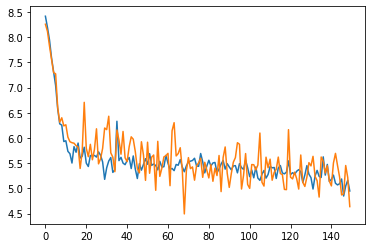

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

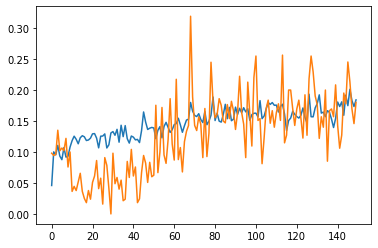

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [48]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([0.001,0.0001,4.5,6.5])

KeyError: ignored

In [49]:
actor_model.save_weights('/content/policy_net_model_3.h5')

In [50]:
#actor_model.load_weights()

In [51]:
def caption_greedy(policy_net,image,tokenizer,word_index,max_length=20):
  caption='startseq'
  for i in range(max_length):
    input_seq=caption.split(' ')
    tokenization=tokenizer.texts_to_sequences(input_seq)
    padding=tf.keras.preprocessing.sequence.pad_sequences([tokenization],maxlen=max_length) 
    predicted_word_index=np.argmax(policy_net.predict([tf.expand_dims(image,axis=0),padding]))
    predicted_word=word_index[predicted_word_index]
    caption+=' '+predicted_word
    if predicted_word =='endseq':
      break
  return caption

In [53]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

Text(0.5, 1.0, 'startseq in is in is on endseq')

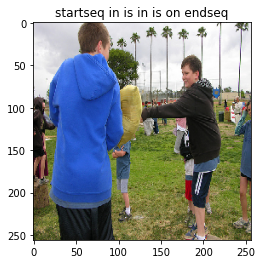

In [54]:
test_img=list(test_cap_tok.keys())[250]
test_photo = load_preprocess_img(image_pth_rt + test_img)
cap=caption_greedy(actor_model,test_photo,tokenizer,word_index)
plt.imshow(test_photo)
plt.title(cap)

In [ ]:
test_dataset = captions_generation(test_cap_tok, vocab_size, image_pth_rt, max_length)

In [ ]:
import nltk
def captions_eval(captions_dic, vocab_size, image_pth_rt,tokenizer, max_length=25, num_captions=1):
    images, input_text_seq, output_text = list(), list(), list()
    batch_iter = 0
    batch_keys = []
    while True:
        for key, desc_list in captions_dic.items():
            # print(key)
            batch_keys.append(key)
            batch_iter += 1
            caption = 0
            # retrieve the photo feature

            photo = load_preprocess_img(image_pth_rt + key)
            for desc in desc_list:
                caption += 1
                desc = np.squeeze(desc)
                input_sequence = []
                for i in range(1, len(desc)):
                    input_sequence.append(desc[:i + 1])
                    images.append(photo)
                input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_sequence, maxlen=max_length,
                                                                          padding='pre')
                if caption == num_captions:
                    break
                #predicted_cap=caption_greedy(policy_net,photo,tokenizer)
                #BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], predicted_cap, weights = [1])
                #print(BLEUscore)
          

In [ ]:
actor_model.evaluate(test_dataset)

   1255/Unknown - 5189s 4s/step - loss: 3.5979 - accuracy: 0.2958

KeyboardInterrupt: ignored